In [5]:
!pip install -q yfinance

In [40]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import plotly.express as px
from scipy.stats import f_oneway

import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # 판다스 워닝 무시

# 데이터 로드 및 클리닝
- QQQ (Invesco QQQ Trust)의 모든 기간 데이터를 가져오고, 컬럼명을 정리

In [41]:
# 모든 기간의 데이터 가져오기
df = yf.Ticker('QQQ').history(period="max")

In [43]:
# 데이터프레임의 각 컬럼 설명
# Open: 거래일의 시작가격
# High: 거래일 중 최고가격
# Low: 거래일 중 최저가격
# Close: 거래일의 종가
# Volume: 거래량 (거래된 주식의 수)
# Dividends: 주당 배당금
# Stock Splits: 주식 분할 비율 (예: 2는 1:2 분할을 의미)

df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
1999-03-10 00:00:00-05:00,43.400446,43.426974,42.684179,43.347389,5232000,0.0,0.0,0.0
1999-03-11 00:00:00-05:00,43.665741,43.917761,42.710719,43.559628,9688600,0.0,0.0,0.0
1999-03-12 00:00:00-05:00,43.400424,43.426952,42.153590,42.498459,8743600,0.0,0.0,0.0
1999-03-15 00:00:00-05:00,42.816815,43.771837,42.365833,43.718781,6369000,0.0,0.0,0.0
1999-03-16 00:00:00-05:00,43.904481,44.275878,43.426970,44.090179,4905800,0.0,0.0,0.0


In [44]:
# 컬럼명을 소문자로 변환하고 공백을 _로 대체
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,open,high,low,close,volume,dividends,stock_splits,capital_gains
Date,,,,,,,,
1999-03-10 00:00:00-05:00,43.400446,43.426974,42.684179,43.347389,5232000,0.0,0.0,0.0
1999-03-11 00:00:00-05:00,43.665741,43.917761,42.710719,43.559628,9688600,0.0,0.0,0.0
1999-03-12 00:00:00-05:00,43.400424,43.426952,42.153590,42.498459,8743600,0.0,0.0,0.0
1999-03-15 00:00:00-05:00,42.816815,43.771837,42.365833,43.718781,6369000,0.0,0.0,0.0
1999-03-16 00:00:00-05:00,43.904481,44.275878,43.426970,44.090179,4905800,0.0,0.0,0.0


In [45]:
df.stock_splits.value_counts()

stock_splits
0.0    6520
2.0       1
Name: count, dtype: int64

Stock Splits (주식 분할)
- 주식 분할은 기업이 기존 주식을 여러 개의 주식으로 나누는 것을 의미합니다
- 예를 들어 2:1 분할의 경우, 기존 1주가 2주로 나뉘며 주가는 1/2로 하락합니다
- 데이터를 보면 애플은 총 5번의 주식 분할이 있었습니다:
  - 2.0 분할이 3회 (1:2 분할)
  - 4.0 분할이 1회 (1:4 분할)
  - 7.0 분할이 1회 (1:7 분할)
- 주식 분할의 목적은 주가를 낮춰 투자자들의 접근성을 높이는 것입니다


QQQ의 경우에도 주식(ETF) 분할이 있을 수 있으므로, 분할 배수를 누적 계산합니다.

In [46]:
# 주식 분할 누적 배수 계산: 분할이 없는 경우 1로 대체
df['split_multiplier'] = (df.stock_splits.replace(0, 1)).cumprod()

In [ ]:
df.isna().sum() # 결측치 확인

open                0
high                0
low                 0
close               0
volume              0
dividends           0
stock_splits        0
capital_gains       0
split_multiplier    0
dtype: int64

---

# Feature Engineering

주식 보조지표 (Technical Indicators)

1. 이동평균선 (Moving Average)
1. RSI (Relative Strength Index)
1. MACD (Moving Average Convergence Divergence)
1. 볼린저 밴드 (Bollinger Bands)

## 기술적 지표 (Technical Indicators) 계산
### 이동평균선(Moving Average)
  - 일정 기간의 주가 평균을 나타내는 지표
  - 단기/중기/장기 추세를 파악하는데 활용
  - 대표적으로 5일, 20일, 60일, 120일 이동평균선 사용

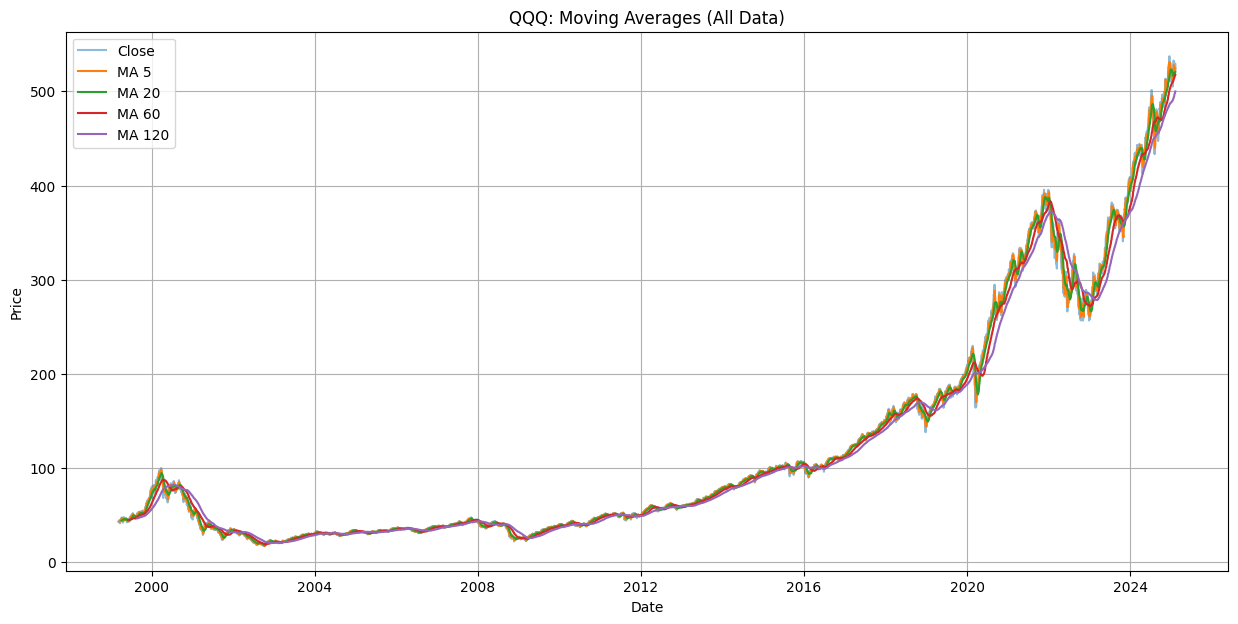

In [50]:
# 이동평균선 계산 (5일, 20일, 60일, 120일)
df['ma5']   = df.close.rolling(window=5).mean()
df['ma20']  = df.close.rolling(window=20).mean()
df['ma60']  = df.close.rolling(window=60).mean()
df['ma120'] = df.close.rolling(window=120).mean()

# 전체 기간 이동평균선 시각화
plt.figure(figsize=(15,7))
plt.plot(df.index, df.close, label='Close', alpha=0.5)
plt.plot(df.index, df.ma5, label='MA 5')
plt.plot(df.index, df.ma20, label='MA 20')
plt.plot(df.index, df.ma60, label='MA 60')
plt.plot(df.index, df.ma120, label='MA 120')
plt.title('QQQ: Moving Averages (All Data)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

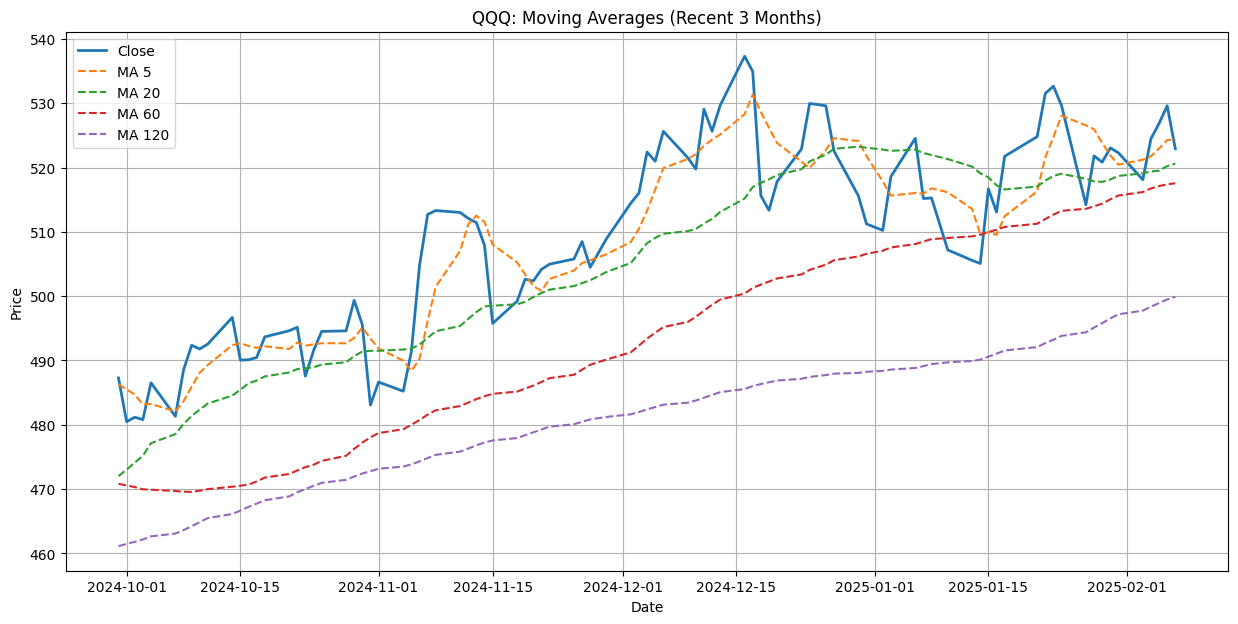

In [52]:
# 최근 3개월(약 90일) 데이터 시각화
recent_3m = df[-90:]
plt.figure(figsize=(15,7))
plt.plot(recent_3m.index, recent_3m.close, label='Close', linewidth=2)
plt.plot(recent_3m.index, recent_3m.ma5, label='MA 5', linestyle='--')
plt.plot(recent_3m.index, recent_3m.ma20, label='MA 20', linestyle='--')
plt.plot(recent_3m.index, recent_3m.ma60, label='MA 60', linestyle='--')
plt.plot(recent_3m.index, recent_3m.ma120, label='MA 120', linestyle='--')
plt.title('QQQ: Moving Averages (Recent 3 Months)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

- 5일 이동평균선(ma5)은 주가의 단기 변동성을 잘 반영하며, 주가와 가장 밀접하게 움직임   

- 20일 이동평균선(ma20)은 중기 추세를 나타내며, 주가의 방향성을 파악하는 데 유용함   

- 60일 이동평균선(ma60)과 120일 이동평균선(ma120)은 장기 추세를 보여주며, 주가의 전반적인 흐름을 이해하는 도움을 줌   

- 최근 주가는 60일 이동평균선 아래로 떨어졌으며, 이는 하락 추세가 지속될 가능성을 시사함   



### RSI (Relative Strength Index)
  - 주가의 상승압력과 하락압력을 비교하여 과매수/과매도 구간 판단
  - 0-100 사이의 값을 가지며, 70이상은 과매수, 30이하는 과매도로 해석
  - 일반적으로 14일을 기준으로 계산

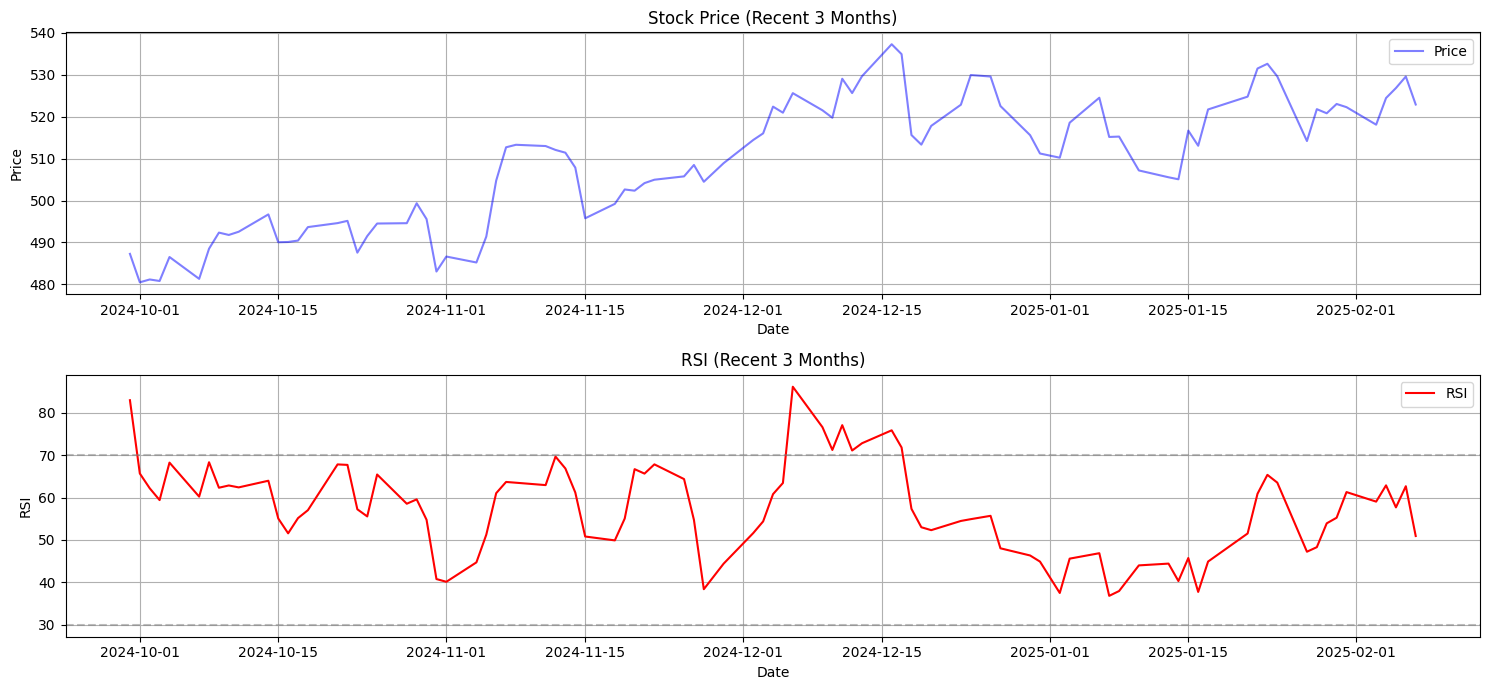

In [ ]:
# RSI 계산 함수
def get_rsi(close, period=14):
    delta = close.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 14일 RSI 계산
df['rsi14'] = get_rsi(df['close'], 14)

# 최근 90일 RSI 시각화
recent_3m = df[-90:]

# 서브플롯 생성
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,7))

# 주가 그래프 (위)
ax1.plot(recent_3m.index, recent_3m.close, 'b-', label='Price', alpha=0.5)
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.set_title('Stock Price (Recent 3 Months)')
ax1.grid(True)
ax1.legend()

# RSI 그래프 (아래)
ax2.plot(recent_3m.index, recent_3m.rsi14, 'r-', label='RSI')
ax2.set_xlabel('Date')
ax2.set_ylabel('RSI')
ax2.set_title('RSI (Recent 3 Months)')
ax2.grid(True)

# 과매수/과매도 구간 표시
ax2.axhline(y=70, color='gray', linestyle='--', alpha=0.5)
ax2.axhline(y=30, color='gray', linestyle='--', alpha=0.5)
ax2.legend()

plt.tight_layout()
plt.show()

### MACD (Moving Average Convergence Divergence)
  - 단기 이동평균선과 장기 이동평균선의 차이를 이용
  - 추세 전환 시점을 포착하는데 유용
  - 12일, 26일 지수이동평균선의 차이와 9일 시그널선 사용

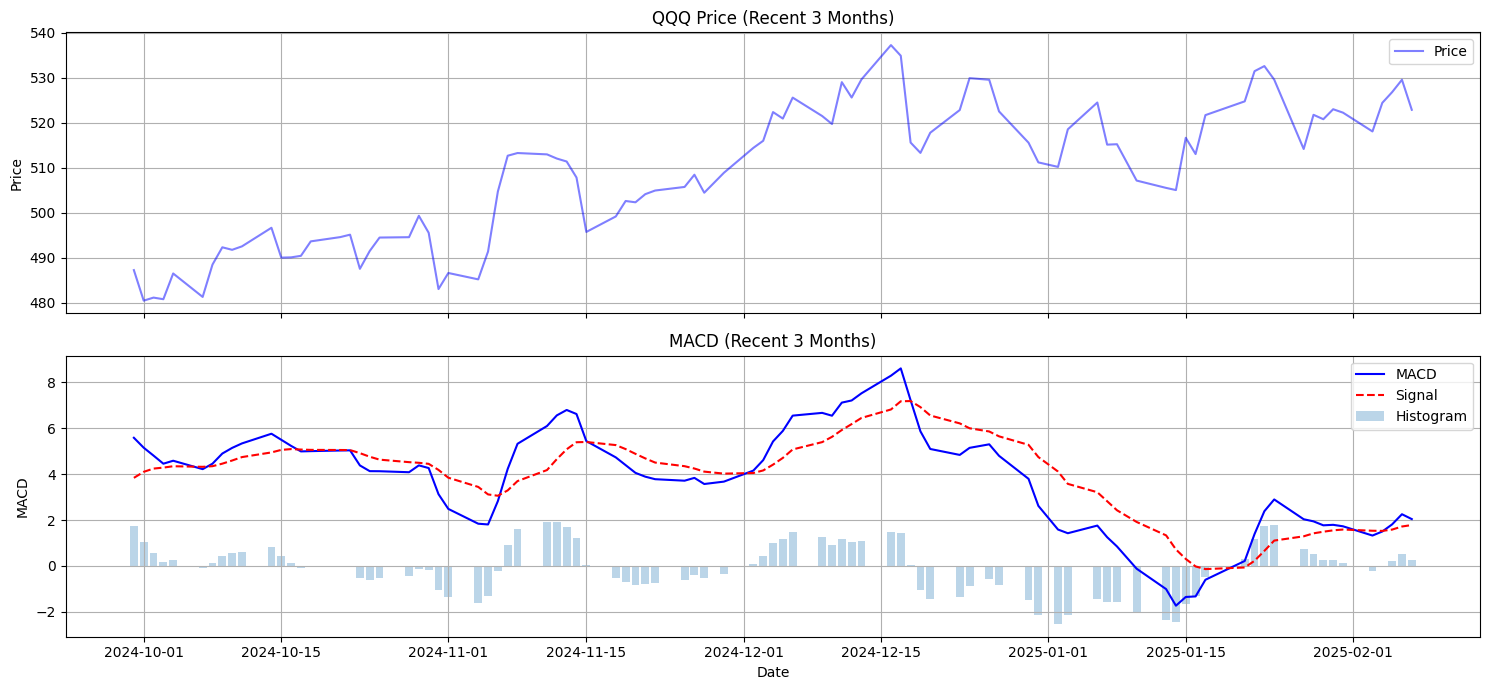

In [54]:
# MACD 계산: 12일 및 26일 EMA 차이와 9일 시그널
exp1 = df['close'].ewm(span=12, adjust=False).mean()
exp2 = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = exp1 - exp2
df['signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# 최근 90일 MACD 시각화
recent_3m = df[-90:]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,7), sharex=True)

ax1.plot(recent_3m.index, recent_3m.close, 'b-', label='Price', alpha=0.5)
ax1.set_title('QQQ Price (Recent 3 Months)')
ax1.set_ylabel('Price')
ax1.grid(True)
ax1.legend()

ax2.plot(recent_3m.index, recent_3m.macd, 'b-', label='MACD')
ax2.plot(recent_3m.index, recent_3m.signal, 'r--', label='Signal')
ax2.bar(recent_3m.index, recent_3m.macd - recent_3m.signal, alpha=0.3, label='Histogram')
ax2.set_title('MACD (Recent 3 Months)')
ax2.set_xlabel('Date')
ax2.set_ylabel('MACD')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()

MACD 분석 결과
* MACD 라인이 시그널 라인을 하향 돌파하는 데드크로스가 발생하여 약세 신호를 보임
* 히스토그램이 음수 영역에 위치하고 있어 단기적으로 하락 추세가 지속될 것으로 예상됨
* 2024년 1월 중순부터 MACD와 시그널 라인의 하향 이격이 커지고 있어 매도 압력이 강화되는 중
* 다만 최근 MACD와 시그널 라인의 간격이 좁아지는 추세여서 반등 가능성도 존재


# 볼린저 밴드 (Bollinger Bands)
  - 이동평균선을 중심으로 표준편차를 이용해 상/하한 밴드 설정
  - 주가의 변동성과 추세를 동시에 파악 가능
  - 20일 이동평균선과 ±2 표준편차를 주로 사용

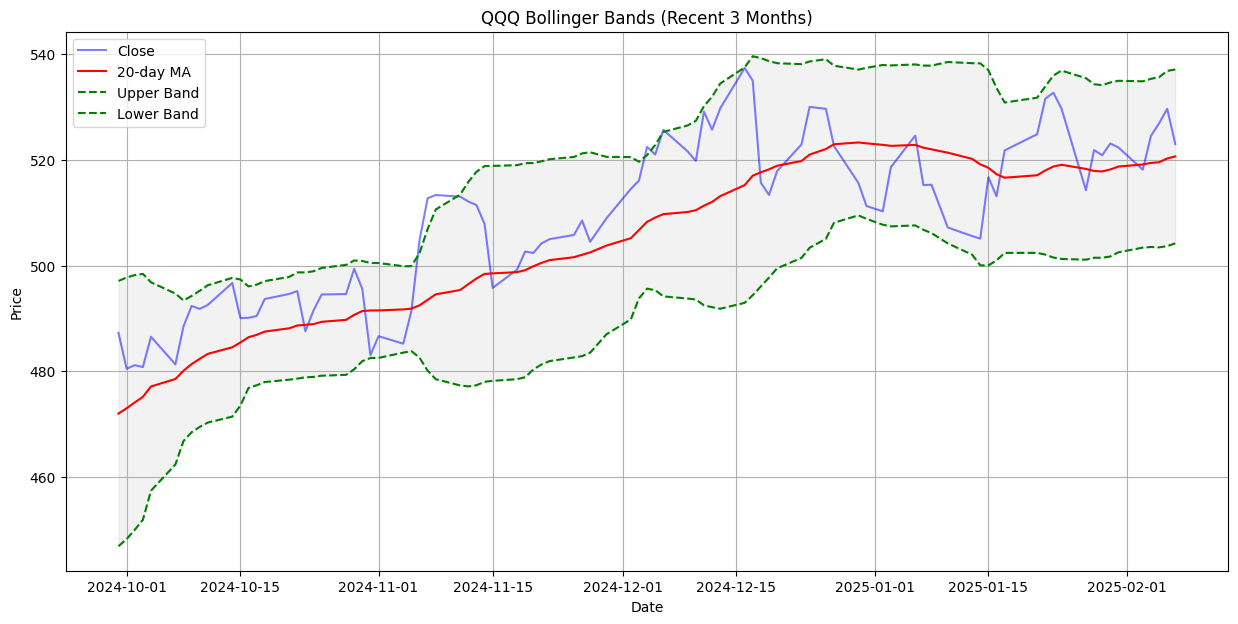

In [55]:
# 20일 이동평균 및 표준편차
df['ma20'] = df['close'].rolling(window=20).mean()
df['std20'] = df['close'].rolling(window=20).std()

df['upper_band'] = df['ma20'] + 2 * df['std20']
df['lower_band'] = df['ma20'] - 2 * df['std20']

# 최근 90일 볼린저 밴드 시각화
recent_3m = df[-90:]
plt.figure(figsize=(15,7))
plt.plot(recent_3m.index, recent_3m.close, 'b-', label='Close', alpha=0.5)
plt.plot(recent_3m.index, recent_3m.ma20, 'r-', label='20-day MA')
plt.plot(recent_3m.index, recent_3m.upper_band, 'g--', label='Upper Band')
plt.plot(recent_3m.index, recent_3m.lower_band, 'g--', label='Lower Band')
plt.fill_between(recent_3m.index, recent_3m.upper_band, recent_3m.lower_band, color='gray', alpha=0.1)
plt.title('QQQ Bollinger Bands (Recent 3 Months)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

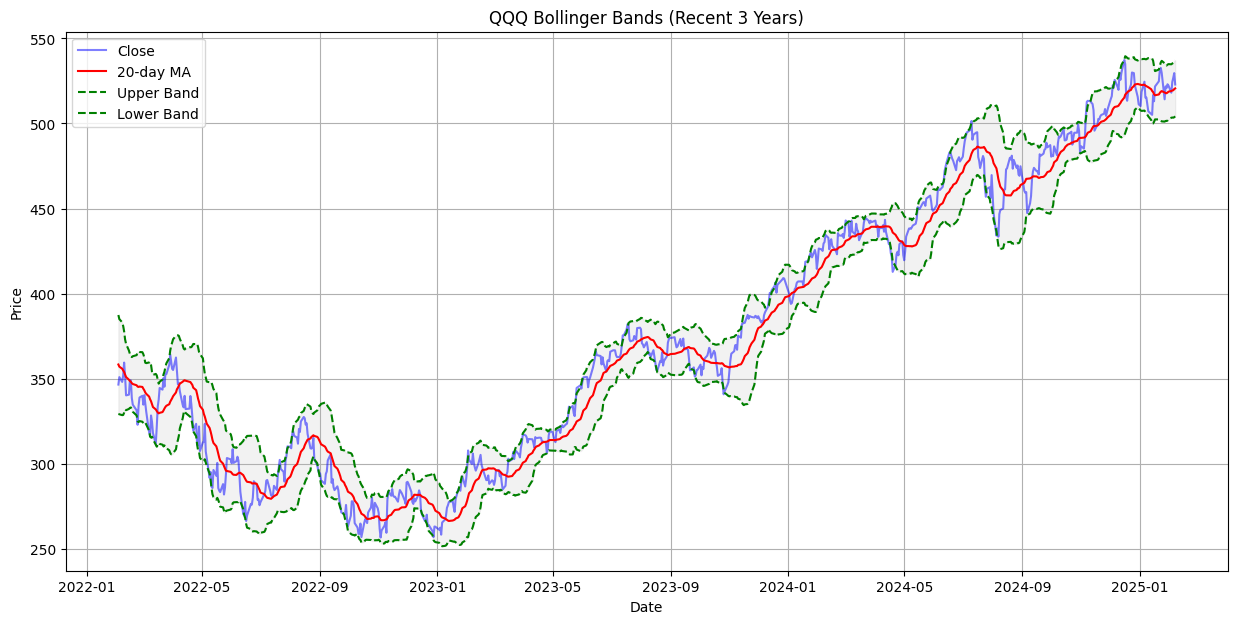

In [56]:
# 최근 3년 (약 756 거래일) 데이터 시각화
recent_3y = df[-756:]
plt.figure(figsize=(15,7))
plt.plot(recent_3y.index, recent_3y.close, 'b-', label='Close', alpha=0.5)
plt.plot(recent_3y.index, recent_3y.ma20, 'r-', label='20-day MA')
plt.plot(recent_3y.index, recent_3y.upper_band, 'g--', label='Upper Band')
plt.plot(recent_3y.index, recent_3y.lower_band, 'g--', label='Lower Band')
plt.fill_between(recent_3y.index, recent_3y.upper_band, recent_3y.lower_band, color='gray', alpha=0.1)
plt.title('QQQ Bollinger Bands (Recent 3 Years)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [58]:
df

,open,high,low,close,volume,dividends,stock_splits,capital_gains,split_multiplier,ma5,ma20,ma60,ma120,rsi14,macd,signal,std20,upper_band,lower_band
Date,,,,,,,,,,,,,,,,,,,
1999-03-10 00:00:00-05:00,43.400446,43.426974,42.684179,43.347389,5232000,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN
1999-03-11 00:00:00-05:00,43.665741,43.917761,42.710719,43.559628,9688600,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,0.016931,0.003386,NaN,NaN,NaN
1999-03-12 00:00:00-05:00,43.400424,43.426952,42.153590,42.498459,8743600,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,-0.054649,-0.008221,NaN,NaN,NaN
1999-03-15 00:00:00-05:00,42.816815,43.771837,42.365833,43.718781,6369000,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,-0.012760,-0.009129,NaN,NaN,NaN
1999-03-16 00:00:00-05:00,43.904481,44.275878,43.426970,44.090179,4905800,0.0,0.0,0.0,1.0,43.442887,NaN,NaN,NaN,NaN,0.049832,0.002664,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-03 00:00:00-05:00,513.469971,520.849976,511.049988,518.109985,40580800,0.0,0.0,0.0,2.0,521.217993,519.090001,516.192190,497.754781,59.035275,1.324853,1.534620,7.855021,534.800043,503.379959
2025-02-04 00:00:00-05:00,518.630005,525.109985,518.229980,524.469971,26046800,0.0,0.0,0.0,2.0,521.749988,519.384499,516.743063,498.375189,62.870041,1.501071,1.527911,7.944794,535.274086,503.494911
2025-02-05 00:00:00-05:00,521.820007,527.010010,520.619995,526.849976,21134100,0.0,0.0,0.0,2.0,522.953979,519.499998,517.111128,498.922380,57.678906,1.811886,1.584706,8.039909,535.579817,503.420180


# 주식 가격 예측 및 상승 분류를 위한 추가 피쳐 엔지니어링

In [59]:
# 일일 수익률 계산
df['daily_return'] = df['close'].pct_change()

# 일일 수익률의 이동평균 및 표준편차 (20일)
df['daily_return_ma20'] = df['daily_return'].rolling(window=20).mean()
df['daily_return_std20'] = df['daily_return'].rolling(window=20).std()

# 거래량 20일 이동평균
df['volume_ma20'] = df['volume'].rolling(window=20).mean()

# 결측치 확인 (초기 데이터 포인트로 인한 NA 발생)
print("총 결측치 수: ", df.isna().sum().sum())

# 결측치 제거
df = df.dropna()
print("결측치 제거 후 남은 NA 개수: ", df.isna().sum().sum())

총 결측치 수:  331
결측치 제거 후 남은 NA 개수:  0


In [60]:
df.isna().sum()

open                  0
high                  0
low                   0
close                 0
volume                0
dividends             0
stock_splits          0
capital_gains         0
split_multiplier      0
ma5                   0
ma20                  0
ma60                  0
ma120                 0
rsi14                 0
macd                  0
signal                0
std20                 0
upper_band            0
lower_band            0
daily_return          0
daily_return_ma20     0
daily_return_std20    0
volume_ma20           0
dtype: int64

- 결측치는 이동 평균 및 표준 편차 계산 시, 초기 데이터 포인트가 부족하여 발생합니다.
- 예를 들어, 120일 이동 평균을 계산하려면 최소 120일의 데이터가 필요합니다.
- 따라서 초기 119일 동안은 결측치가 발생하게 됩니다.
- 결측치가 존재하는 rows는 삭제합니다.




In [23]:
df = df.dropna()
df.isna().sum().sum()

np.int64(0)

---

In [24]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock_splits',
       'split_multiplier', 'ma5', 'ma20', 'ma60', 'ma120', 'rsi14', 'macd',
       'signal', 'std20', 'upper_band', 'lower_band', 'daily_return',
       'daily_return_ma20', 'daily_return_std20', 'volume_ma20'],
      dtype='object')

In [25]:
df.daily_return

Date
1981-06-04 00:00:00-04:00    0.019840
1981-06-05 00:00:00-04:00   -0.015563
1981-06-08 00:00:00-04:00   -0.035571
1981-06-09 00:00:00-04:00    0.020490
1981-06-10 00:00:00-04:00    0.012048
                               ...   
2025-02-03 00:00:00-05:00   -0.033856
2025-02-04 00:00:00-05:00    0.021008
2025-02-05 00:00:00-05:00   -0.001418
2025-02-06 00:00:00-05:00    0.003226
2025-02-07 00:00:00-05:00   -0.023969
Name: daily_return, Length: 11011, dtype: float64

---

# 상승 분류 모델 제작을 위한 label 생성

In [61]:
# 일일 수익률이 0.01보다 크면 1, 그렇지 않으면 0을 할당하여 'bull' 열을 생성합니다.
df['bull'] = df['daily_return'].apply(lambda x: 1 if x > 0.01 else 0)
df

,open,high,low,close,volume,dividends,stock_splits,capital_gains,split_multiplier,ma5,...,macd,signal,std20,upper_band,lower_band,daily_return,daily_return_ma20,daily_return_std20,volume_ma20,bull
Date,,,,,,,,,,,,,,,,,,,,,
1999-08-27 00:00:00-04:00,51.723713,51.730346,50.695739,50.828381,9635400,0.0,0.0,0.0,1.0,51.254169,...,0.779857,0.417889,1.829871,52.368515,45.049032,-0.009947,0.002981,0.018393,11657430.0,0
1999-08-30 00:00:00-04:00,51.040619,51.199789,49.979483,50.112125,10141600,0.0,0.0,0.0,1.0,51.121527,...,0.728123,0.479936,1.845471,52.509808,45.127924,-0.014092,0.002414,0.018750,11682390.0,0
1999-08-31 00:00:00-04:00,50.456997,50.987564,49.342804,50.669224,14590400,0.0,0.0,0.0,1.0,51.031332,...,0.723734,0.528696,1.866220,52.704839,45.239958,0.011117,0.003295,0.018723,11761660.0,1
1999-09-01 00:00:00-04:00,50.987557,51.465068,50.669216,51.033981,10752000,0.0,0.0,0.0,1.0,50.796554,...,0.741145,0.571186,1.842476,52.872230,45.502327,0.007199,0.004561,0.018043,11637880.0,0
1999-09-02 00:00:00-04:00,50.085585,51.120192,49.979471,50.854908,14583200,0.0,0.0,0.0,1.0,50.699724,...,0.732055,0.603360,1.832359,53.020783,45.691347,-0.003509,0.003591,0.017923,11432280.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-03 00:00:00-05:00,513.469971,520.849976,511.049988,518.109985,40580800,0.0,0.0,0.0,2.0,521.217993,...,1.324853,1.534620,7.855021,534.800043,503.379959,-0.008003,0.000847,0.013003,34064705.0,0
2025-02-04 00:00:00-05:00,518.630005,525.109985,518.229980,524.469971,26046800,0.0,0.0,0.0,2.0,521.749988,...,1.501071,1.527911,7.944794,535.274086,503.494911,0.012275,0.000643,0.012777,33914070.0,1
2025-02-05 00:00:00-05:00,521.820007,527.010010,520.619995,526.849976,21134100,0.0,0.0,0.0,2.0,522.953979,...,1.811886,1.584706,8.039909,535.579817,503.420180,0.004538,0.000295,0.012559,33165290.0,0


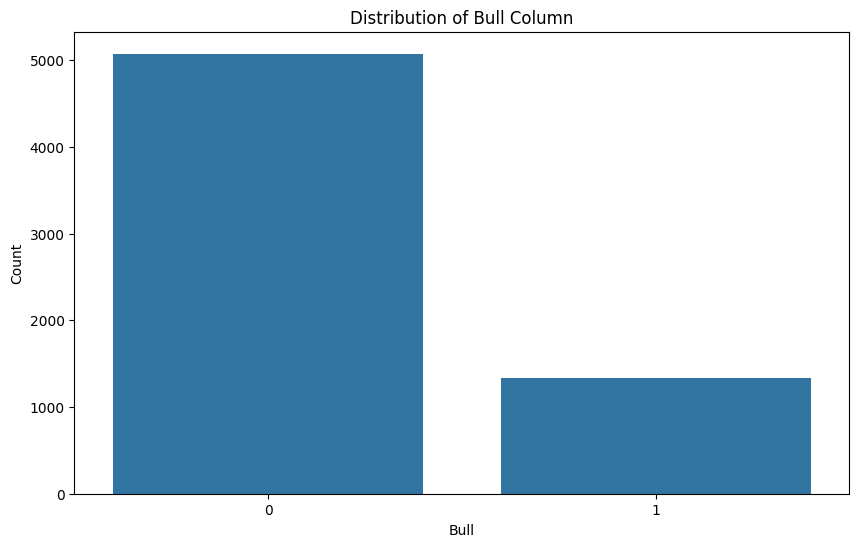

In [62]:
import seaborn as sns

# bull 컬럼의 값 분포를 확인합니다.
df['bull'].value_counts()

# bull 컬럼의 값 분포를 시각화합니다.
plt.figure(figsize=(10, 6))
sns.countplot(x='bull', data=df)
plt.title('Distribution of Bull Column')
plt.xlabel('Bull')
plt.ylabel('Count')
plt.show()

daily_return          0.629034
daily_return_std20    0.221440
signal                0.083948
std20                 0.075415
split_multiplier      0.075391
macd                  0.069363
volume_ma20           0.068017
volume                0.065863
daily_return_ma20     0.055267
dividends             0.026914
rsi14                 0.009546
ma120                 0.007215
stock_splits          0.006397
close                 0.005210
ma60                  0.004598
upper_band            0.004586
lower_band            0.003090
high                  0.002782
ma5                   0.001183
open                  0.001107
ma20                  0.000909
low                   0.000706
capital_gains              NaN
Name: bull, dtype: float64


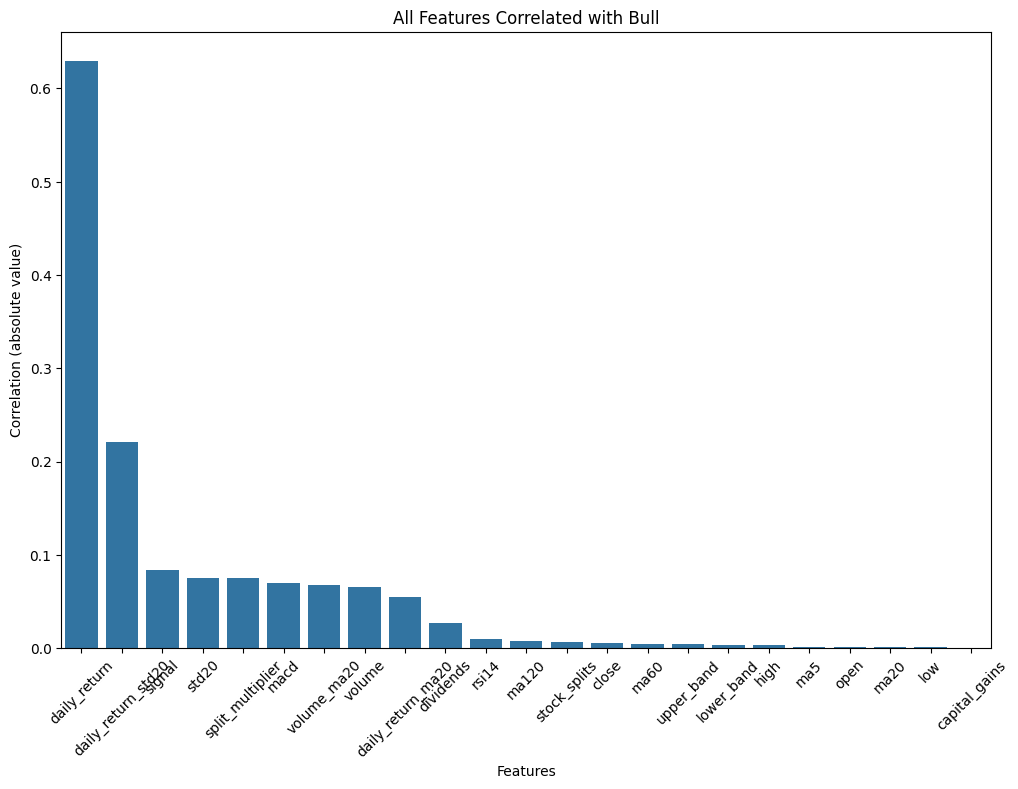

In [63]:
# correlation_matrix을 구합니다.
correlation_matrix = df.corr()

# bull 컬럼과 상관계수가 높은 모든 컬럼을 절대값 기준으로 정렬합니다.
all_corr = correlation_matrix['bull'].abs().sort_values(ascending=False)[1:]  # bull 컬럼 제외
print(all_corr)

# 상관계수가 높은 모든 컬럼들을 시각화합니다.
plt.figure(figsize=(12, 8))
sns.barplot(x=all_corr.index, y=all_corr.values)
plt.title('All Features Correlated with Bull')
plt.xlabel('Features')
plt.ylabel('Correlation (absolute value)')
plt.xticks(rotation=45)
plt.show()


----

# 급상승 데이터 분석

ValueError: Could not interpret value `super_bull` for `x`. An entry with this name does not appear in `data`.

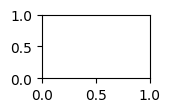

In [73]:
columns_to_plot = ['open', 'high', 'low', 'close', 'volume', 'ma5', 'ma20', 'ma60', 'ma120', 
                   'rsi14', 'macd', 'signal', 'std20', 'upper_band', 'lower_band', 
                   'daily_return', 'daily_return_ma20', 'daily_return_std20', 'volume_ma20']

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(5, 4, i)
    sns.boxplot(x='super_bull', y=column, data=df)
    plt.title(f'{column.capitalize()} by Super Bull')
    plt.xlabel('Super Bull')
    plt.ylabel(column.capitalize())

plt.tight_layout()
plt.show()


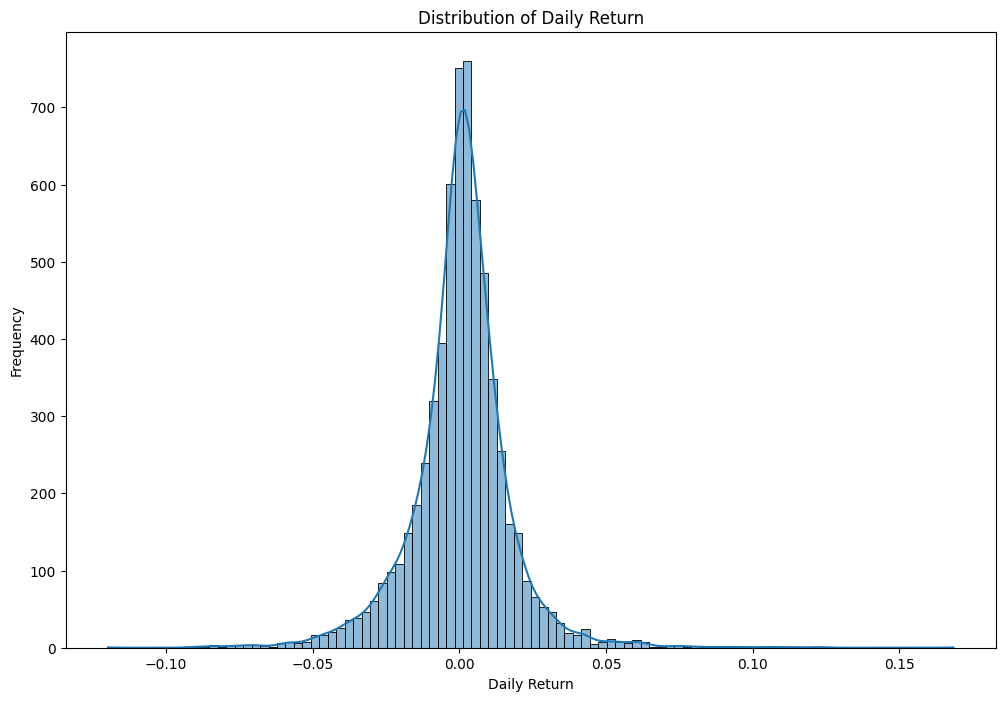

In [68]:
# 일일 수익률 분포 확인
plt.figure(figsize=(12,8))
sns.histplot(df['daily_return'], bins=100, kde=True)
plt.title('Distribution of Daily Return')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

In [69]:
# super_bull 값에 따른 주요 피쳐들의 분포를 Boxplot으로 비교
columns_to_plot = ['open', 'high', 'low', 'close', 'volume', 'ma5', 'ma20', 'ma60', 'ma120',
                   'rsi14', 'macd', 'signal', 'std20', 'upper_band', 'lower_band',
                   'daily_return', 'daily_return_ma20', 'daily_return_std20', 'volume_ma20']

plt.figure(figsize=(20, 15))

<Figure size 2000x1500 with 0 Axes>

<Figure size 2000x1500 with 0 Axes>

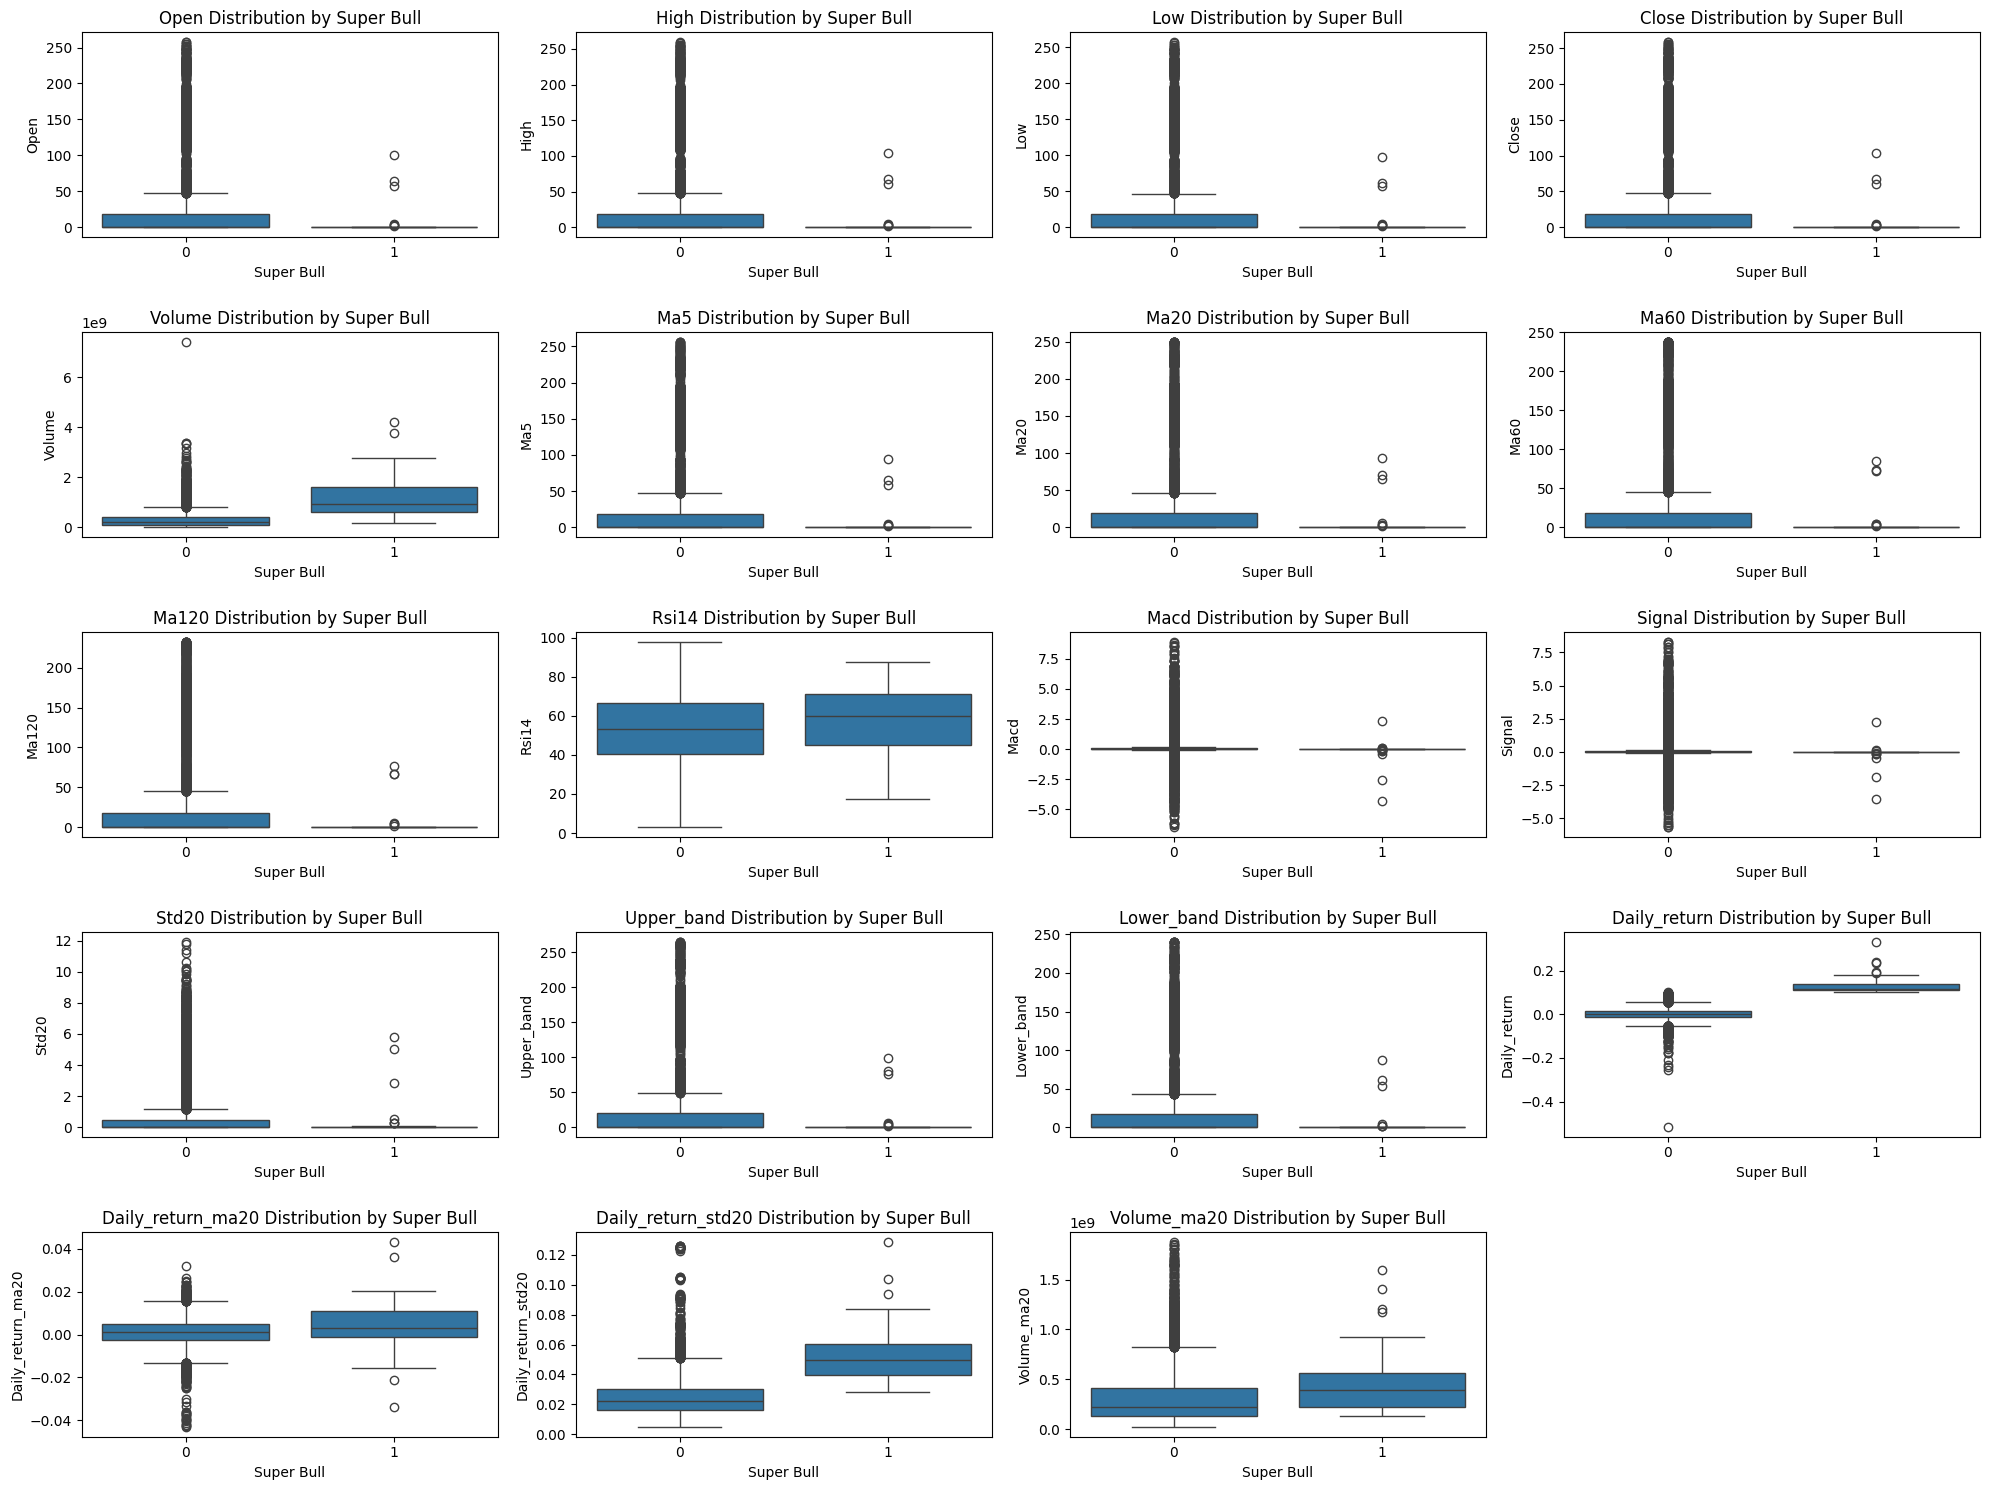

In [32]:
# super_bull이 1인 것들과 아닌 것들의 다른 컬럼들이 어떻게 경향이 다른지 시각화합니다.
plt.figure(figsize=(20, 15))

# open, high, low, close, volume, ma5, ma20, ma60, ma120, rsi14, macd, signal, std20, upper_band, lower_band, daily_return, daily_return_ma20, daily_return_std20, volume_ma20 컬럼에 대해 boxplot을 그립니다.
columns_to_plot = ['open', 'high', 'low', 'close', 'volume', 'ma5', 'ma20', 'ma60', 'ma120', 'rsi14', 'macd', 'signal', 'std20', 'upper_band', 'lower_band', 'daily_return', 'daily_return_ma20', 'daily_return_std20', 'volume_ma20']
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(5, 4, i)
    sns.boxplot(x='super_bull', y=column, data=df)
    plt.title(f'{column.capitalize()} Distribution by Super Bull')
    plt.xlabel('Super Bull')
    plt.ylabel(column.capitalize())

plt.tight_layout()
plt.show()


----

# 데이터를 차원 축소하여 시각화


- PCA (Principal Component Analysis)와 t-SNE (t-Distributed Stochastic Neighbor Embedding)는 모두 차원 축소 기법이지만, 그 목적과 방법이 다릅니다.

- PCA와 t-SNE 모두 고차원 데이터를 저차원으로 변환하여 시각화를 용이하게 하는 기법입니다.

- PCA는 데이터의 분산을 최대한 보존하면서 주요 패턴을 찾고, 노이즈를 줄이는 선형 기법입니다.

- t-SNE는 데이터의 국소적인 구조를 보존하면서 클러스터링을 시각화하고, 데이터 간의 유사성을 강조하는 비선형 기법입니다.

- 요약하자면, PCA는 데이터의 전체적인 분산을 보존하는 데 중점을 두고, t-SNE는 데이터의 국소적인 유사성을 보존하는 데 중점을 둡니다.


### PCA

In [34]:
! pip install plotly

  Using cached plotly-6.0.0-py3-none-any.whl.metadata (5.6 kB)
Using cached plotly-6.0.0-py3-none-any.whl (14.8 MB)


In [37]:
! pip install nbformat

  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached fastjsonschema-2.21.1-py3-none-any.whl.metadata (2.2 kB)
  Using cached jsonschema-4.23.0-py3-none-any.whl.metadata (7.9 kB)
  Using cached attrs-25.1.0-py3-none-any.whl.metadata (10 kB)
  Using cached jsonschema_specifications-2024.10.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached referencing-0.36.2-py3-none-any.whl.metadata (2.8 kB)
  Using cached rpds_py-0.22.3-cp312-cp312-win_amd64.whl.metadata (4.2 kB)
Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
Using cached fastjsonschema-2.21.1-py3-none-any.whl (23 kB)
Using cached jsonschema-4.23.0-py3-none-any.whl (88 kB)
Using cached attrs-25.1.0-py3-none-any.whl (63 kB)
Using cached jsonschema_specifications-2024.10.1-py3-none-any.whl (18 kB)
Using cached referencing-0.36.2-py3-none-any.whl (26 kB)
Using cached rpds_py-0.22.3-cp312-cp312-win_amd64.whl (235 kB)


In [71]:
# 분석에 사용할 피쳐 선택 (라벨 관련 컬럼은 제외)
features = df.drop(columns=['super_bull', 'daily_return', 'bull'])

# PCA로 3차원 축소
pca = PCA(n_components=3)
pca_result = pca.fit_transform(features)

pca_df = pd.DataFrame(data=pca_result, columns=['pca_one', 'pca_two', 'pca_three'])
pca_df['daily_return'] = df['daily_return'].values

# Plotly를 이용한 3D 산점도
fig = px.scatter_3d(pca_df, x='pca_one', y='pca_two', z='pca_three', 
                    color='daily_return', title='3D PCA of QQQ Data (Colored by Daily Return)')
fig.show()


KeyError: "['super_bull'] not found in axis"

- 이 3D PCA 시각화는 주식 데이터의 일일 수익률에 따른 분포를 보여줍니다.   

- 그래프에서 볼 수 있듯이, 대부분의 데이터 포인트는 특정 영역에 집중되어 있으며,   

- 이는 일일 수익률이 특정 범위 내에서 변동하는 경향이 있음을 시사합니다.   

- 또한, 일부 데이터 포인트는 다른 영역에 위치하여 극단적인 수익률을 나타낼 수 있습니다.   


### t-SNE

In [ ]:
from sklearn.manifold import TSNE
import plotly.express as px

# T-sne를 사용하여 데이터의 차원을 3차원으로 축소합니다.
tsne = TSNE(n_components=3, random_state=42)
tsne_result = tsne.fit_transform(df.drop(columns=['super_bull', 'daily_return', 'bull']))

# T-sne 결과를 새로운 데이터프레임에 저장합니다.
tsne_df = pd.DataFrame(data=tsne_result, columns=['tsne_one', 'tsne_two', 'tsne_three'])
tsne_df['daily_return'] = df['daily_return'].values

# daily_return의 값에 따라 다른 색으로 시각화합니다.
fig = px.scatter_3d(tsne_df, x='tsne_one', y='tsne_two', z='tsne_three', color='daily_return', title='3D T-sne of Stock Data by Daily Return')
fig.show()


In [ ]:
from sklearn.cluster import KMeans

# bull과 절대값 기준으로 상관관계가 가장 높았던 3개 컬럼을 찾습니다.
correlation_matrix = df.corr().abs()
top_3_columns = correlation_matrix['bull'].sort_values(ascending=False).index[1:4]

# KMeans를 사용하여 데이터의 군집을 4개로 나눕니다.
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_result = kmeans.fit_predict(df[top_3_columns])

# KMeans 결과를 새로운 데이터프레임에 저장합니다.
kmeans_df = df.copy()
kmeans_df['kmeans_cluster'] = kmeans_result

# 군집 결과를 시각화합니다.
fig = px.scatter_3d(kmeans_df, x=top_3_columns[0], y=top_3_columns[1], z=top_3_columns[2], color='kmeans_cluster', title='3D Scatter of Stock Data by KMeans Clusters')
fig.show()


In [ ]:
kmeans_df.columns

---

# Baseline characteristics

In [ ]:
import pandas as pd
from scipy.stats import f_oneway

# 전체 숫자 표시 설정
pd.options.display.float_format = "{:.4f}".format

group_col = "kmeans_cluster"

table_rows = []
for col in df.columns:
    group_vals = []
    for c in sorted(kmeans_df[group_col].unique()):
        group_data = kmeans_df[kmeans_df[group_col]==c][col].dropna()
        group_vals.append(group_data)
    f_stat, p_val = f_oneway(*group_vals)
    means = [g.mean() for g in group_vals]
    table_rows.append([col, *means, round(p_val,4)])

col_names = ["Var"] + [f"Mean_Cluster{i}" for i in range(4)] + ["p-value"]
result_df = pd.DataFrame(table_rows, columns=col_names)
result_df

- RSI14가 높아 과매수 상태로 해석 가능함    

- 거래량 또한 높아 유동성 큰 편임    

- MACD와 signal이 양의 값으로 추세상 상승세 가능성 있음    

- daily_return_ma20이 가장 높아 최근 추세 우상향 경향 보임    
